In [1]:
import os, sys
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

main_dir = os.path.dirname(os.getcwd())
data_dir = f"{main_dir}/data/HoxB8"
os.listdir(data_dir)

['GSE146128_TFnet_exon_counts.csv',
 'GSE146128_exp1_exon_counts.csv',
 'GSE146128_Tfnet_interactions_exon_counts.csv',
 'GSE146128_TFnet_exon_counts.h5ad',
 'GSE146128_Tfnet_interactions_exon_counts.h5ad',
 'GSE146128_exp1_exon_counts.h5ad',
 'TFnet_test_glm.h5ad',
 'GLM_result.pkl',
 'TFnet_test_glm_10xmatrices',
 'TFnext_exon_2khvg_scTransform.rds']

# process raw data

In [2]:
adata_raw = sc.read_h5ad(f"{data_dir}/GSE146128_TFnet_exon_counts.h5ad")
anno_genes = list(filter(lambda x: "ENSMUSG" in x, adata_raw.var_names))
adata_G = adata_raw[:,anno_genes].copy()

In [5]:
# normalize raw adata_G
sc.pp.filter_genes(adata_G, min_cells = 200)
sc.pp.normalize_total(adata_G, target_sum=1e4)
sc.pp.log1p(adata_G)
# select top variable genes
sc.pp.highly_variable_genes(adata_G, n_top_genes = 2000) 
high_var_genes = adata_G.var_names[adata_G.var.highly_variable]


In [6]:
adata_hvg = adata_raw[:,high_var_genes].copy()
adata_hvg.write_h5ad(f"{data_dir}/TFnet_test_glm.h5ad")

# regress out

In [2]:
from MiniPert import model

/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata_hvg = sc.read_h5ad(f"{data_dir}/TFnet_test_glm.h5ad")

In [4]:
# initiate a model without fitting
pert_glm = model.Perturb_NBGLM(adata=adata_hvg, perturb_key='TF', plate_key="Plate")

# if not fitted
pert_glm.fit(n_jobs=40)

# if you have a saved version
# pert_glm.load_from("Mini-Perturb/result/checkpoint/Hoxb8_2k_fit.ckpt")

Fitting Negative Binomial regression 
	for 2000 genes 
	with 54 independent variables + 1 intercept
Gene ~ Gata3 + Gata2 + Nfe2 + emptyV + R26 +  ...  + Plate13 + Plate15 + Plate16 + Plate17 + Plate18
Checkpoint file loaded from /home/wergillius/Project/Mini-Perturb/result/checkpoint/Hoxb8_2k_fit.ckpt

 Testing DEGs of all conditions


In [5]:
betas = pert_glm.adata.varm['Betas']
print(betas.shape) 
# 2000 genes, 54 variables + 1 intercept

(2000, 55)


In [6]:
# you can check
print(pert_glm.beta_df.shape)
pert_glm.beta_df.head()

(55, 2000)


Unnamed: 0,ENSMUSG00000000078,ENSMUSG00000000088,ENSMUSG00000000148,ENSMUSG00000000555,ENSMUSG00000000711,ENSMUSG00000000811,ENSMUSG00000000823,ENSMUSG00000000876,ENSMUSG00000000901,ENSMUSG00000000915,...,ENSMUSG00000115210,ENSMUSG00000115219,ENSMUSG00000115276,ENSMUSG00000115771,ENSMUSG00000115866,ENSMUSG00000116249,ENSMUSG00000116694,ENSMUSG00000116802,ENSMUSG00000116941,ENSMUSG00000116987
intercept,-0.892262,0.682998,-0.748770,-0.032065,-1.393696,-1.287835,-0.647652,-1.118515,-1.622505,-1.140869,...,-1.872606,-0.866659,-1.460205,-3.062090,0.0,-2.882202,-4.308852,-1.983491,-3.708732,-4.359100
Gata3,-0.059000,0.134884,-0.042920,-0.068623,-0.077071,-0.204136,-0.063141,0.247843,1.178023,0.006174,...,-0.262048,-0.030949,0.085090,-0.231732,0.0,-0.155458,0.398746,-0.215733,-0.647286,-0.301017
Gata2,0.040089,0.038168,-0.037040,0.009076,-0.019371,-0.198440,0.073819,0.115592,-0.008293,0.155762,...,0.004983,-0.004438,-0.004402,0.068747,0.0,-0.250050,0.497944,-0.199365,-0.757758,-0.170155
Nfe2,0.025938,0.058995,-0.056573,-0.010316,-0.050686,-0.083089,-0.008348,0.130088,0.202486,-0.016928,...,-0.350596,-0.122004,-0.021250,0.179692,0.0,-0.336848,0.116031,-0.254794,-0.456699,-0.638156
emptyV,-0.090876,-0.003098,0.021690,0.059996,0.011782,0.007055,0.006583,-0.052309,-0.036050,0.005349,...,-0.024983,0.019239,-0.059795,-0.115560,0.0,-0.123080,-0.209794,-0.127748,-0.278237,-0.359888


# visualize uncorrected

In [65]:
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.tl.pca(adata_hvg)
sc.pp.neighbors(adata_hvg, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_hvg)

/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


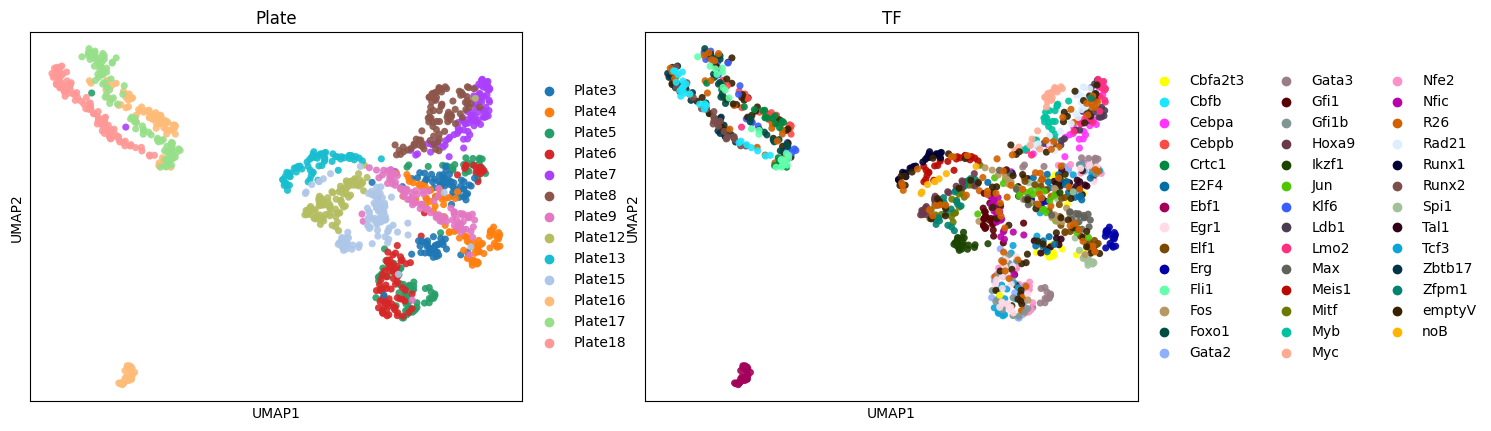

In [76]:
sc.pl.umap(adata_hvg, color=['Plate','TF'], alpha=0.9)

## visualize corrected adata

In [7]:
# call Perturb_NBGLM method : regress_out_plate_effect 
corrected_x = pert_glm.regress_out_plate_effect()

In [8]:
adata_corrected = adata_hvg.copy()
adata_corrected.X = corrected_x

In [9]:
adata_corrected.obs['Treatment'] = adata_corrected.obs.TF.map(map_treatment)

In [23]:
sc.pp.normalize_total(adata_corrected, target_sum=1e5)
sc.pp.log1p(adata_corrected)

sc.tl.pca(adata_corrected)
sc.pp.neighbors(adata_corrected)
sc.tl.umap(adata_corrected, maxiter=3000)

/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


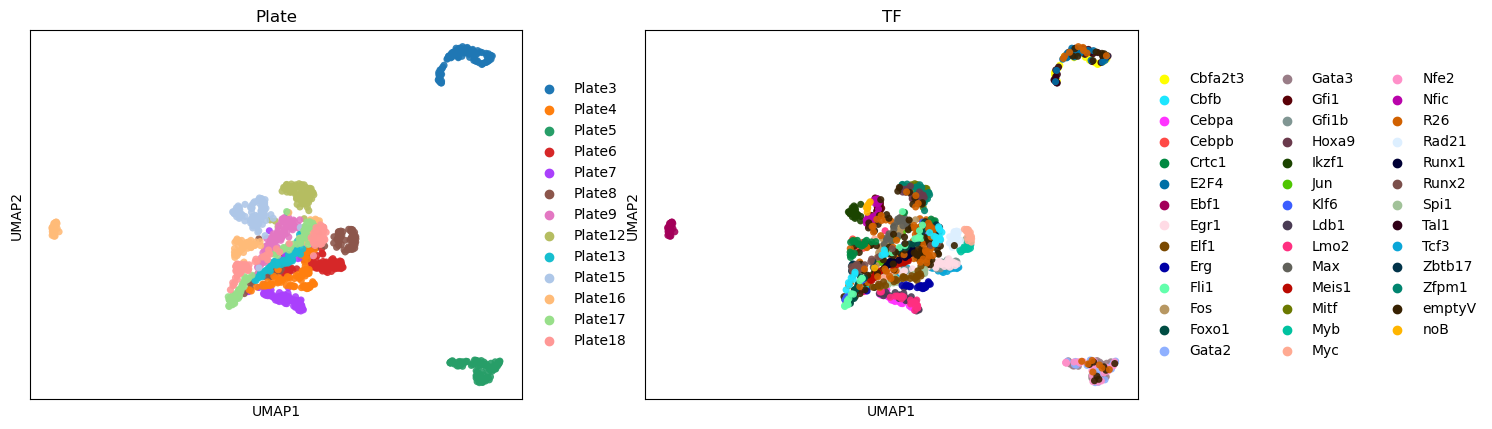

In [26]:
sc.pl.umap(adata_corrected, color=['Plate','TF'], alpha=0.9)

/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


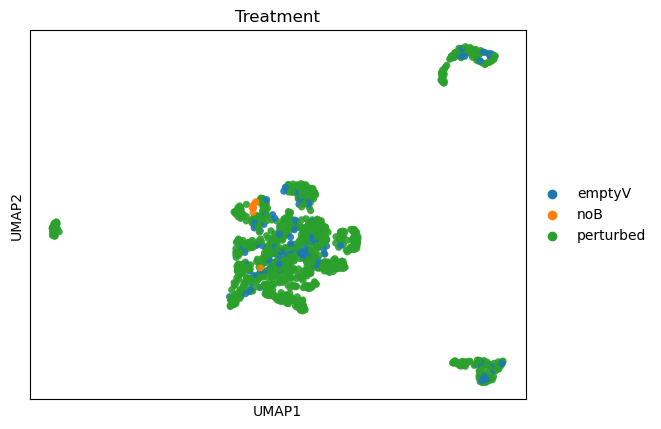

In [27]:
sc.pl.umap(adata_corrected, color=['Treatment'],  alpha=0.9)

# visualize condition / perturbation by betas

In [14]:
import anndata as ad

In [15]:
betas = pert_glm.beta_df.loc[pert_glm.perturb_variable].values

Pert_adata = ad.AnnData(
    X=betas,
    var=pert_glm.adata.var,
    obs=pd.DataFrame(pert_glm.perturb_variable, columns=['perturbation']).set_index("perturbation")
)

In [16]:
Pert_adata.obs['Pert'] = list(Pert_adata.obs.index)

In [44]:
sc.tl.pca(Pert_adata)
sc.pp.neighbors(Pert_adata, n_neighbors=4, metric='cosine')
sc.tl.leiden(Pert_adata, resolution=0.5)
sc.tl.umap(Pert_adata)

/home/wergillius/.conda/envs/GLM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


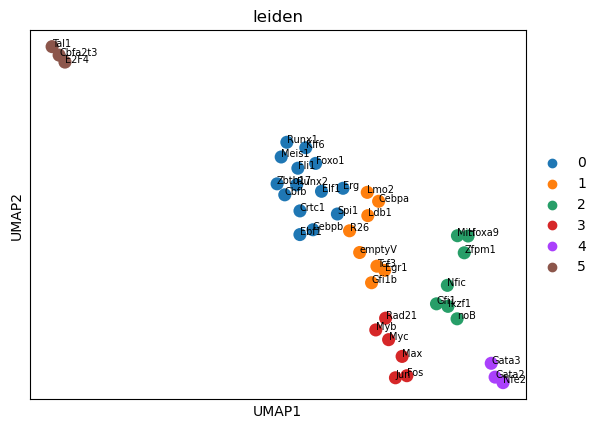

In [45]:
fig = sc.pl.umap(Pert_adata, s=355, color='leiden', return_fig=True, show=False)
ax= fig.gca()

for i,n in enumerate(Pert_adata.obs_names):
    x = Pert_adata.obsm['X_umap'][i,0]
    y = Pert_adata.obsm['X_umap'][i,1]
    ax.text(x,y,n, size=7)